In [117]:
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

### Exercise 4.7

Write a program for policy iteration and re-solve Jack’s car
rental problem with the following changes. One of Jack’s employees at the first location
rides a bus home each night and lives near the second location. She is happy to shuttle
one car to the second location for free. Each additional car still costs £2, as do all cars
moved in the other direction. In addition, Jack has limited parking space at each location.
If more than 10 cars are kept overnight at a location (after any moving of cars), then an
additional cost of £4 must be incurred to use a second parking lot (independent of how
many cars are kept there). These sorts of nonlinearities and arbitrary dynamics often
occur in real problems and cannot easily be handled by optimization methods other than
dynamic programming. To check your program, first replicate the results given for the
original problem.

### Define functions

In [140]:
def policy_iteration(rental_fee=10, 
                     move_cost=2, 
                     lam_rental=(3, 4),
                     lam_return=(3, 2),
                     max_cars=20, 
                     max_move=5,
                     free_moves=(0, 1),
                     max_capacity=10,
                     extra_capacity_cost=4,
                     gamma=0.9, 
                     theta=0.1,
                     ):
    
    # initialise value function and policy
    V, pi = initialisation(max_cars)
    
    policy_stable = False
    it = 1
    while not policy_stable:
    
        print('Running iteration {} of policy evaluation...'.format(it))
    
        # evaluate policy
        policy_evaluation(V, pi, rental_fee, move_cost,
                          lam_rental, lam_return, 
                          max_cars, max_move, free_moves, 
                          max_capacity, extra_capacity_cost,
                          gamma, theta)
        
        print('Running iteration {} of policy improvement...'.format(it))
    
        # improve policy
        V, pi, policy_stable = policy_improvement(V, pi, rental_fee, move_cost,
                                                  lam_rental, lam_return, 
                                                  max_cars, max_move, free_moves, 
                                                  max_capacity, extra_capacity_cost,
                                                  gamma, theta)
        
        it += 1
        print('-' * 50)
    
    print('Policy stable')

    return V, pi
    
    
def initialisation(max_cars):
    
    # the states are the number of cars at each of the two locations, between 0 and 20
    # initialise the value of all states as 0
    V = {(cars_1, cars_2): 0 for cars_1 in range(max_cars + 1) 
                                      for cars_2 in range(max_cars + 1)}
    
    # the actions are the net number of cars moved from location 1 to location 2 overnight
    # initialise the actions of all states as 0
    pi = {s: 0 for s in V.keys()}

    return V, pi
    
    
def policy_evaluation(V, pi, rental_fee, move_cost, 
                      lam_rental, lam_return, 
                      max_cars, max_move, free_moves, 
                      max_capacity, extra_capacity_cost,
                      gamma, theta):
    
    delta = theta + 1
    
    # until accuracy of estimation is met...
    while delta > theta:
        
        delta = 0
        
        # for each state...
        for s, v in V.items():
            
            # update V(s)
            V[s] = expected_return(V, s, pi[s], rental_fee, move_cost, 
                                   lam_rental, lam_return, 
                                   max_cars, max_move, free_moves, 
                                   max_capacity, extra_capacity_cost, 
                                   gamma)
            
            # update delta
            delta = max(delta, abs(v - V[s]))
            
    return V

  
def policy_improvement(V, pi, rental_fee, move_cost,
                       lam_rental, lam_return, 
                       max_cars, max_move, free_moves, 
                       max_capacity, extra_capacity_cost,
                       gamma, theta):
    
    delta = 0
    
    # for each state...
    for s, v in V.items():
        
        old_action = pi[s]
        cars_1 = s[0]
        cars_2 = s[1]

        # compute value of each possible action
        n1 = min(min(max_move, cars_2), max_cars - cars_1)        
        n2 = min(min(max_move, cars_1), max_cars - cars_2)
        possible_actions = np.arange(-n1, n2 + 1)
        action_values = [expected_return(V, s, a, rental_fee, move_cost, 
                                         lam_rental, lam_return, 
                                         max_cars, max_move, free_moves, 
                                         max_capacity, extra_capacity_cost, 
                                         gamma) 
                         for a in possible_actions]
        
        # get the best action and its value
        i_max = np.argmax(action_values)
        best_action = possible_actions[i_max]
        new_v = action_values[i_max]
        
        # update policy
        pi[s] = best_action
        
        # update delta
        delta = max(delta, new_v - v)
        
    # stable?
    if delta > theta:
        policy_stable = False
    else:
        policy_stable = True
                      
    return V, pi, policy_stable


def expected_return(V, s, a, rental_fee, move_cost, 
                    lam_rental, lam_return, 
                    max_cars, max_move, free_moves, 
                    max_capacity, extra_capacity_cost,
                    gamma):
    
    # compute the cost of moving the cars
    n = abs(a)
    if a > 0:
        n = max(0, n - free_moves[1])
    elif a < 0:
        n = max(0, n - free_moves[0])   
    cost = move_cost * n 

    # compute the number of cars at each location at the start of the next day
    cars_1 = min(s[0] - a, max_cars)
    cars_2 = min(s[1] + a, max_cars)
    
    # compute the extra capacity costs at each location
    extra_cost_1 = extra_capacity_cost if cars_1 > max_capacity else 0
    extra_cost_2 = extra_capacity_cost if cars_2 > max_capacity else 0

    # for n = 0 to cars_1, compute the probability that n cars 
    # are rented from location 1 the next day 
    p_rentals_1 = prob_rentals(cars_1, lam_rental[0])

    # do the same for location 2
    p_rentals_2 = prob_rentals(cars_2, lam_rental[1])

    # compute the expected rental fees for the next day at each location
    exp_rent_1 = expected_rent(p_rentals_1, rental_fee)
    exp_rent_2 = expected_rent(p_rentals_2, rental_fee)

    # expected immediate reward is expected rental fees - costs
    exp_immediate_reward = (exp_rent_1 + exp_rent_2) - (cost + extra_cost_1 + extra_cost_2)

    # for n = 0 to max_cars, compute the probability that n cars
    # are returned to location 1 during the next day
    p_returns_1 = prob_returns(max_cars, lam_return[0])

    # do the same for location 2
    p_returns_2 = prob_returns(max_cars, lam_return[1])

    # for n = 0 to 20, compute the probability that there are 
    # n cars at location 1 at the end of the next day
    p_cars_1 = prob_cars_next_day(cars_1, p_rentals_1, p_returns_1, max_cars)

    # do the same for location 2
    p_cars_2 = prob_cars_next_day(cars_2, p_rentals_2, p_returns_2, max_cars)

    # compute the expected future reward
    x = [V[(cars_1, cars_2)] * p1 * p2 for cars_1, p1 in enumerate(p_cars_1)
                                       for cars_2, p2 in enumerate(p_cars_2)]
    exp_future_reward = gamma * sum(x)

    # compute expected return
    exp_return = exp_immediate_reward + exp_future_reward
    
    return exp_return
            
                
def prob_rentals(cars, lam):
    
    p_rentals = np.zeros(cars + 1)
    for n in range(cars):
        p_rentals[n] = poisson(n, lam)
    p_rentals[-1] = 1 - p_rentals[:-1].sum()
    
    return p_rentals


def prob_returns(max_cars, lam):
    
    p_returns = np.zeros(max_cars + 1)
    for n in range(max_cars):
        p_returns[n] = poisson(n, lam)
    p_returns[-1] = 1 - p_returns[:-1].sum()
    
    return p_returns


def prob_cars_next_day(cars_current, p_rentals, p_returns, max_cars):
    
    p_cars = np.zeros(max_cars + 1)
    for rentals, p_rental in enumerate(p_rentals):
        for returns, p_return in enumerate(p_returns):
            cars_next = min(cars_current - rentals + returns, max_cars)
            p_cars[cars_next] += p_rental * p_return 
            
    return p_cars
    

def expected_rent(p_rentals, rental_fee):
    r = (p_rentals * np.arange(len(p_rentals))).sum() * rental_fee
    return r
    
    
def poisson(n, lam):    
    return ((lam ** n) / math.factorial(n)) * np.exp(-lam)

### Run policy iteration for the original problem

In [141]:
V, pi = policy_iteration(free_moves=(0, 0),
                         max_capacity=20,
                         extra_capacity_cost=0)

Running iteration 1 of policy evaluation...
Running iteration 1 of policy improvement...
--------------------------------------------------
Running iteration 2 of policy evaluation...
Running iteration 2 of policy improvement...
--------------------------------------------------
Running iteration 3 of policy evaluation...
Running iteration 3 of policy improvement...
--------------------------------------------------
Running iteration 4 of policy evaluation...
Running iteration 4 of policy improvement...
--------------------------------------------------
Policy stable


### Convert policy and value functions to matrices

In [142]:
V_mat = np.zeros((21, 21))
pi_mat = np.zeros((21, 21))
for s, a in pi.items():
    V_mat[s[0], s[1]] = V[s]
    pi_mat[s[0], s[1]] = a

### Plot the policy

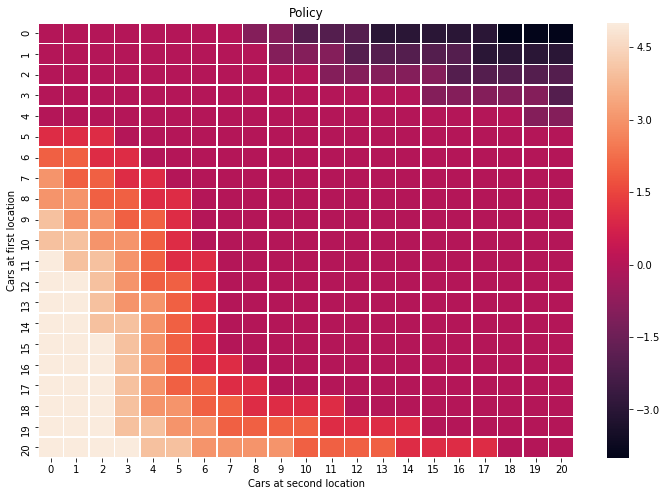

In [143]:
plt.figure(figsize=(12, 8))
sns.heatmap(pi_mat, linewidth=0.5)
plt.ylabel('Cars at first location')
plt.xlabel('Cars at second location')
plt.title('Policy')
plt.show()

### Plot the value function

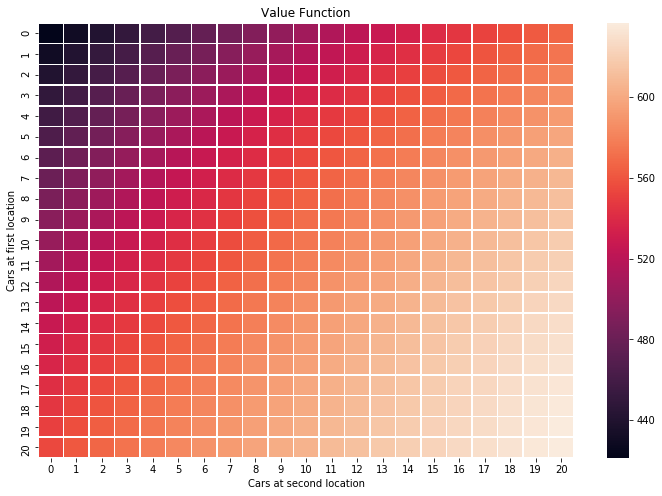

In [144]:
plt.figure(figsize=(12, 8))
sns.heatmap(V_mat, linewidth=0.5)
plt.ylabel('Cars at first location')
plt.xlabel('Cars at second location')
plt.title('Value Function')
plt.show()

### They appear to agree with the plots in the book

### Run policy iteration for the new problem

In [145]:
V, pi = policy_iteration(free_moves=(0, 1),
                         max_capacity=10,
                         extra_capacity_cost=4)

Running iteration 1 of policy evaluation...
Running iteration 1 of policy improvement...
--------------------------------------------------
Running iteration 2 of policy evaluation...
Running iteration 2 of policy improvement...
--------------------------------------------------
Running iteration 3 of policy evaluation...
Running iteration 3 of policy improvement...
--------------------------------------------------
Running iteration 4 of policy evaluation...
Running iteration 4 of policy improvement...
--------------------------------------------------
Policy stable


### Convert policy and value functions to matrices

In [146]:
V_mat = np.zeros((21, 21))
pi_mat = np.zeros((21, 21))
for s, a in pi.items():
    V_mat[s[0], s[1]] = V[s]
    pi_mat[s[0], s[1]] = a

### Plot the policy

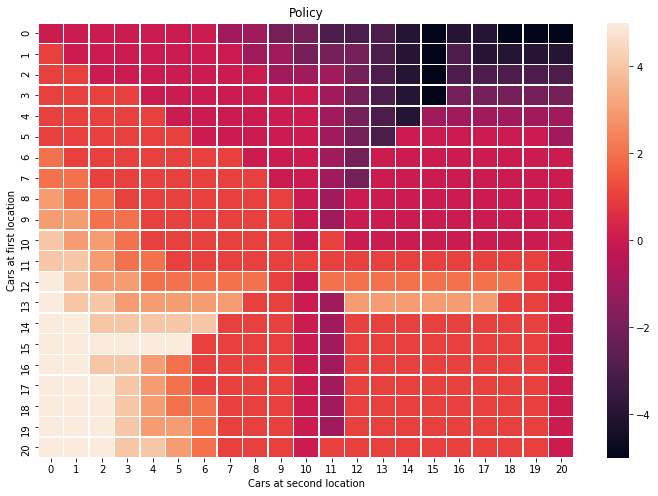

In [147]:
plt.figure(figsize=(12, 8))
sns.heatmap(pi_mat, linewidth=0.5)
plt.ylabel('Cars at first location')
plt.xlabel('Cars at second location')
plt.title('Policy')
plt.show()

### Plot the value function

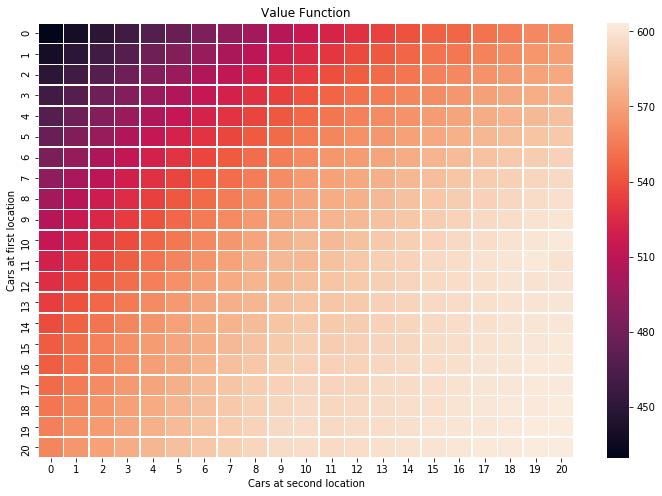

In [148]:
plt.figure(figsize=(12, 8))
sns.heatmap(V_mat, linewidth=0.5)
plt.ylabel('Cars at first location')
plt.xlabel('Cars at second location')
plt.title('Value Function')
plt.show()